##QUESTION 1: How to find the healthiest food options (based on low calories and sugar)?

###Tool: Healthy Food Finder

In [ ]:
import requests
import time
import json

# Cache to store API responses and avoid redundant calls
cache = {}

# API Base URL
SEARCH_URL = "https://world.openfoodfacts.org/cgi/search.pl"
SLEEP_TIME = 1  # Sleep time in seconds to avoid excessive requests

def fetch_products_by_name(product_name):
    # Fetch a list of products by name from Open Food Facts with caching and rate-limiting
    if product_name in cache:
        return cache[product_name]
    params = {
        "search_terms": product_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
    }
    response = requests.get(SEARCH_URL, params=params)
    time.sleep(SLEEP_TIME)  # Avoid overwhelming API requests

    if response.status_code == 200:
        data = response.json()
        products = data.get("products", [])
        cache[product_name] = products
        return products
    return []

def extract_nutritional_info(product):
    # Extract key nutritional details from a product
    try:
        return {
            "name": product.get("product_name", "Unknown"),
            "nutri_score": product.get("nutriscore_grade", "Unknown"),
            "calories": product.get("nutriments", {}).get("energy-kcal_100g", float("inf")),
            "sugar": product.get("nutriments", {}).get("sugars_100g", float("inf")),
        }
    except Exception as e:
        print(f"Error extracting nutritional info: {e}")
        return {}

def find_healthier_options(product_name):
    # Find and rank healthier alternatives for a given product name
    print("\n Searching for healthier alternatives")
    products = fetch_products_by_name(product_name)
    if not products:
        print("\n No products found. Try a different name.")
        return
    processed_products = [extract_nutritional_info(p) for p in products if p.get("product_name")]

    # Filter out products with missing nutritional data
    valid_products = [p for p in processed_products if p["calories"] != float("inf") and p["sugar"] != float("inf")]
    if not valid_products:
        print("\n No comparable products with complete nutrition info found.")
        return

    # Sort by lowest calories first, then sugar, then best Nutri-Score
    ranked_products = sorted(valid_products, key=lambda p: (p["calories"], p["sugar"], p["nutri_score"]))

    # Display top 5 healthier alternatives
    print("\n Top 5 Most Healthy Options (Sorted by Low Calories & Sugar):\n")
    for i, product in enumerate(ranked_products[:5], 1):
        print(f"{i}. {product['name']}")
        print(f"    Nutri-Score: {product['nutri_score'].upper()}")
        print(f"    Calories: {product['calories']:.1f} kcal per 100g")
        print(f"    Sugar: {product['sugar']:.1f}g per 100g\n")

def main():
    # Main function to interactively ask for product input and display healthier options
    while True:
        print("\n===  Healthy Food Finder  ===")
        product_name = input("\n Enter a food name (or 'quit' to exit): ").strip()
        if product_name.lower() == 'quit':
            print("\n Thank you for using Healthy Food Finder!")
            break
        if product_name:
            find_healthier_options(product_name)
        else:
            print(" Please enter a valid product name.")

# Run the program
if __name__ == "__main__":
    main()


===  Healthy Food Finder  ===

 Enter a food name (or 'quit' to exit): potato chips

 Searching for healthier alternatives

 Top 5 Most Healthy Options (Sorted by Low Calories & Sugar):

1. Oven Baked Sweet Potato Fries
    Nutri-Score: C
    Calories: 156.0 kcal per 100g
    Sugar: 13.0g per 100g

2. Hash Browns
    Nutri-Score: C
    Calories: 169.0 kcal per 100g
    Sugar: 0.5g per 100g

3. Crispy French Fries
    Nutri-Score: B
    Calories: 250.0 kcal per 100g
    Sugar: 0.5g per 100g

4. Sour Cream & Onion Potato Chips
    Nutri-Score: C
    Calories: 432.0 kcal per 100g
    Sugar: 4.4g per 100g

5. Barbeque Potato Chips
    Nutri-Score: C
    Calories: 435.0 kcal per 100g
    Sugar: 8.3g per 100g


===  Healthy Food Finder  ===

 Enter a food name (or 'quit' to exit): quit

 Thank you for using Healthy Food Finder!


##QUESTION 2: Does this product align with my dietary restrictions?

###Tool: Dietary Compatibility Scanner


In [ ]:
import requests
import time

# Cache to store API responses
cache = {}

# API Base URL
SEARCH_URL = "https://world.openfoodfacts.org/cgi/search.pl"
PRODUCT_URL = "https://world.openfoodfacts.org/api/v0/product/{}.json"
SLEEP_TIME = 0.5  # Reduce sleep time to improve performance
ALLERGENS_LIST = ["Milk", "Eggs", "Peanuts", "Tree nuts", "Soy", "Wheat", "Fish", "Shellfish", "Sesame"]
DIETARY_OPTIONS = {
    "vegan": "en:vegan",
    "vegetarian": "en:vegetarian",
    "gluten-free": "en:gluten-free",
    "lactose-free": "en:lactose-free"
}

def fetch_product_by_name(product_name):
    # Fetch a list of products by name from Open Food Facts with caching and rate-limiting
    if product_name in cache:
        return cache[product_name]  # Return cached results
    params = {
        "search_terms": product_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
        "fields": "product_name,code"
    }
    response = requests.get(SEARCH_URL, params=params)
    time.sleep(SLEEP_TIME)
    if response.status_code == 200:
        data = response.json()
        products = data.get("products", [])
        cache[product_name] = products  # Store in cache
        return products
    return []

def fetch_product_details(barcode):
    # Fetch product details using barcode from Open Food Facts
    if barcode in cache:
        return cache[barcode]  # Return cached details
    response = requests.get(PRODUCT_URL.format(barcode))
    time.sleep(SLEEP_TIME)
    if response.status_code == 200:
        data = response.json()
        if data.get("status") == 1:
            cache[barcode] = data["product"]  # Store in cache
            return data["product"]
    return None

def check_allergens(product):
    # Check allergens present in the product
    allergens = product.get("allergens_tags", [])
    allergen_list = [a.replace("en:", "").capitalize() for a in allergens]
    if not allergen_list:
        return "No allergens listed"
    return ", ".join(allergen_list)

def check_dietary_restrictions(product, restrictions):
    # Check if a product meets the given dietary restrictions
    results = {}
    dietary_tags = product.get("ingredients_analysis_tags", [])
    for restriction in restrictions:
        tag = DIETARY_OPTIONS.get(restriction)
        if tag in dietary_tags:
            results[restriction] = "Suitable"
        else:
            results[restriction] = "Not Suitable"
    return results

def check_product_allergens_and_diet():
    # Ask the user for product name, allergens, and dietary preferences, then check compatibility
    print("\n===  Dietary Compatibility Scanner  ===")
    product_name = input("\nEnter the food name (e.g., 'bread', 'milk', 'pasta'): ")
    products = fetch_product_by_name(product_name)
    if not products:
        print("\n No products found. Try a different name.")
        return
    print("\nAvailable products:")
    for i, product in enumerate(products[:10], 1):
        print(f"{i}. {product.get('product_name', 'Unknown')} (Barcode: {product.get('code', 'N/A')})")
    selected_index = int(input("\n Select a product by number: ")) - 1
    if selected_index < 0 or selected_index >= len(products):
        print(" Invalid selection.")
        return
    selected_product = fetch_product_details(products[selected_index]["code"])
    if not selected_product:
        print("\nProduct details not found.")
        return

    # Check allergens
    allergens = check_allergens(selected_product)

    # Ask user for dietary restrictions
    print("\n Dietary Options Available: Vegan, Vegetarian, Gluten-Free, Lactose-Free")
    user_restrictions = input("Do you have any dietary restrictions or allergens you would like to check for this product? \n (e.g., vegan, gluten-free, lactose-free, or allergens like milk, peanuts, etc.): ").strip().lower().split(",")
    user_restrictions = [r.strip() for r in user_restrictions if r.strip() in DIETARY_OPTIONS]
    dietary_results = check_dietary_restrictions(selected_product, user_restrictions)

    # Display Results
    print("\n Allergen and Dietary Information:")
    print(f" Product Name: {selected_product.get('product_name', 'Unknown')}")
    print(f" Barcode: {selected_product.get('code', 'N/A')}\n")
    print(f" Allergens: {allergens}")
    if dietary_results:
        for restriction, result in dietary_results.items():
            print(f" {restriction.capitalize()}: {result}")
    else:
        print(" No dietary restrictions selected.")

def main():
    # Main function to check allergens and dietary compatibility for products
    check_product_allergens_and_diet()

# Run the program
if __name__ == "__main__":
    main()


===  Dietary Compatibility Scanner  ===

Enter the food name (e.g., 'bread', 'milk', 'pasta'): lasagna

Available products:
1. Lasagne all'uovo (Barcode: 8076800376999)
2. Lasagne Platten (Barcode: 8076809523738)
3. Lasagna (Barcode: 8480000044877)
4. Lasagne Pasta (Barcode: 5000436101925)
5. Lasagnes à la bolognaise (Barcode: 3166352968591)
6. Lasagnes (Barcode: 20411978)
7. Beef Lasagne (Barcode: 00206310)
8. Lasagnes à la bolognaise (Barcode: 3302740047534)
9. Lasaña Fácil (Barcode: 8410173072025)
10.  (Barcode: 20163723)

 Select a product by number: 4

 Dietary Options Available: Vegan, Vegetarian, Gluten-Free, Lactose-Free
Do you have any dietary restrictions or allergens you would like to check for this product? 
 (e.g., vegan, gluten-free, lactose-free, or allergens like milk, peanuts, etc.): gluten-free, milk

 Allergen and Dietary Information:
 Product Name: Lasagne Pasta
 Barcode: 5000436101925

 Allergens: Gluten
 Gluten-free: Not Suitable


##QUESTION 3: How can I make informed decisions about processed foods?

###Tool: Food Processing Analyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.8 MB/s eta 0:00:00

===  Food Processing Analyzer  ===

Search Options:
1. Search by Product Name
2. Search by Barcode
3. Exit
Select (1-3): 1

Enter a product name (e.g., yogurt, chocolate)
Product name: sprite

Searching...

Found products (sorted by processing score, higher is less processed):

1. Sprite
    Processing Score: 35/100
    NOVA Score: 4/4
    Additives: 1
    Ingredients: 3.0

2. sprite slim 25cl
    Processing Score: 30/100
    NOVA Score: 4/4
    Additives: 2
    Ingredients: 11.0

3. Sprite
    Processing Score: 10/100
    NOVA Score: 4/4
    Additives: 6
    Ingredients: 18.0

4. sprite 500ml
    Processing Score: 10/100
    NOVA Score: 4/4
    Additives: 6
    Ingredients: 10.0

Enter a number to analyze product
Select #: 1

 Processing Analysis Report for Sprite

1. Processing Classification
    NOVA Group: 4/4
    Classificatio

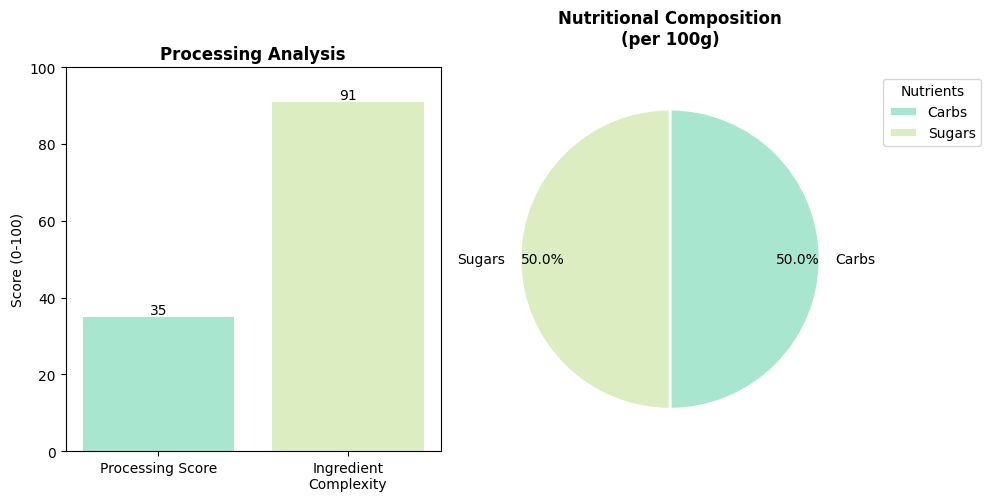


Search Options:
1. Search by Product Name
2. Search by Barcode
3. Exit
Select (1-3): 3

 Thank you for using Food Processing Analyzer!


In [ ]:
!pip install requests_cache
import requests
import requests_cache
import pandas as pd
import matplotlib.pyplot as plt
import time
from typing import Dict, Optional, List

class FoodAnalyzer:
    API_BASE = "https://world.openfoodfacts.org/api/v0/product/"
    SEARCH_ENDPOINT = "https://world.openfoodfacts.org/cgi/search.pl"

    def __init__(self):
        requests_cache.install_cache('food_cache', expire_after=6*3600)
        self.session = requests.Session()
        self.request_interval = 0.1
        self.last_request = 0

    def _rate_limited_get(self, url: str, params: dict = None) -> Optional[dict]:
        # Make rate-limited API requests
        elapsed = time.time() - self.last_request
        if elapsed < self.request_interval:
            time.sleep(self.request_interval - elapsed)
        try:
            response = self.session.get(url, params=params, timeout=10)
            response.raise_for_status()
            self.last_request = time.time()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Request Failed: {str(e)}")
            return None

    def search_by_name(self, query: str, max_results: int = 5) -> pd.DataFrame:
        # Search products by name, focusing on processing information
        params = {
            'search_terms': query,
            'page_size': max_results,
            'json': 1,
            'fields': ('product_name,code,nova_group,additives_tags,'
                      'ingredients_text,ingredients_n,ingredients_analysis_tags')
        }
        data = self._rate_limited_get(self.SEARCH_ENDPOINT, params)
        if not data or 'products' not in data:
            return pd.DataFrame()
        products = []
        for product in data['products']:
            if not product.get('product_name'):
                continue

            # Extract processing information
            nova_score = int(product.get('nova_group', 4))
            additives_count = len(product.get('additives_tags', []))
            ingredients_count = product.get('ingredients_n', 0)

            # Calculate a simple processing score (higher is less processed)
            processing_score = 100 - (nova_score * 15 + min(additives_count * 5, 40))
            products.append({
                'product_name': product.get('product_name', 'Unknown'),
                'nova_score': nova_score,
                'additives_count': additives_count,
                'ingredients_count': ingredients_count,
                'processing_score': max(0, processing_score),
                'code': product.get('code', '')
            })
        df = pd.DataFrame(products)
        if not df.empty:
            df = df.sort_values('processing_score', ascending=False)
        return df

    def get_product_analysis(self, barcode: str) -> Optional[Dict]:
        # Get detailed product analysis
        data = self._rate_limited_get(f"{self.API_BASE}{barcode}.json")
        if not data or data.get('status') != 1:
            return None
        product = data['product']
        nutriments = product.get('nutriments', {})

        # Calculate scores
        nova_score = int(product.get('nova_group', 4))
        additives_count = len(product.get('additives_tags', []))
        ingredients_count = product.get('ingredients_n', 0)
        processing_score = 100 - (nova_score * 15 + min(additives_count * 5, 40))

        return {
            'name': product.get('product_name', 'Unknown'),
            'code': barcode,
            'nova_score': nova_score,
            'processing_score': max(0, processing_score),
            'ingredients_count': ingredients_count,
            'additives': [a.replace('en:', '') for a in product.get('additives_tags', [])],
            'ingredients': product.get('ingredients_text', 'No ingredients information available'),
            'nutrition': {
                'calories': nutriments.get('energy-kcal_100g', 0),
                'protein': nutriments.get('proteins_100g', 0),
                'carbohydrates': nutriments.get('carbohydrates_100g', 0),
                'fat': nutriments.get('fat_100g', 0),
                'fiber': nutriments.get('fiber_100g', 0),
                'sugars': nutriments.get('sugars_100g', 0)
            },
            'processing_info': {
                'nova_group_explanation': self._get_nova_explanation(nova_score),
                'additives_count': additives_count,
                'ingredients_count': ingredients_count
            }
        }

    def _get_nova_explanation(self, nova_score: int) -> str:
        # Get explanation for NOVA score
        explanations = {
            1: "Unprocessed or minimally processed foods",
            2: "Processed culinary ingredients",
            3: "Processed foods",
            4: "Ultra-processed foods"
        }
        return explanations.get(nova_score, "Unknown processing level")

    def visualize_processing(self, analysis: Dict):
        # Create visualization of product processing metrics and nutrition
        plt.figure(figsize=(10, 5))

        # Processing scores subplot
        plt.subplot(1, 2, 1)
        metrics = ['Processing Score', 'Ingredient\nComplexity']

        # Calculate ingredient complexity score
        ingredients_count = analysis['ingredients_count']
        if ingredients_count == 0:
            ingredient_complexity = 0
        else:
            # 1-5 ingredients: 90-100
            # 6-10 ingredients: 70-89
            # 11-15 ingredients: 50-69
            # 16-20 ingredients: 30-49
            # >20 ingredients: <30
            ingredient_complexity = max(0, 100 - (ingredients_count * 3))
        scores = [
            analysis['processing_score'],
            ingredient_complexity
        ]
        colors = ['#a8e6cf', '#dcedc1']
        bars = plt.bar(metrics, scores, color=colors)
        plt.ylim(0, 100)
        plt.title('Processing Analysis', fontweight='bold')
        plt.ylabel('Score (0-100)')

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

        # Nutritional composition subplot
        plt.subplot(1, 2, 2)
        nutrition = analysis['nutrition']

        # Get values and sort them
        nutrients_data = [
            ('Protein', nutrition['protein']),
            ('Fat', nutrition['fat']),
            ('Carbs', nutrition['carbohydrates']),
            ('Sugars', nutrition['sugars'])
        ]

        # Filter out zeros
        valid_data = [(name, value) for name, value in nutrients_data if value > 0]
        labels, values = zip(*valid_data)
        total = sum(values)

        if total > 0:
            # Softer color palette
            colors = ['#a8e6cf', '#dcedc1', '#ff9999', '#ffcc99']

            # Create pie chart with legend
            patches, texts, autotexts = plt.pie(
                values,
                labels=labels,
                colors=colors[:len(valid_data)],
                autopct='%1.1f%%',
                pctdistance=0.85,
                startangle=90,  # Start from the top (90 degrees)
                counterclock=False,  # Go clockwise
                wedgeprops={'edgecolor': 'white', 'linewidth': 2}
            )

            # Set text colors to black
            plt.setp(autotexts, color="black", size=10)
            plt.setp(texts, color="black", size=10)

            # Add legend
            plt.legend(title="Nutrients",
                      bbox_to_anchor=(1.05, 1),
                      loc='upper left')

            plt.title('Nutritional Composition\n(per 100g)',
                     pad=20, fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'No nutrition\ndata available',
                    ha='center', va='center', fontsize=12)
            plt.axis('off')

        plt.tight_layout()
        plt.show(block=False)
        plt.pause(0.1)

    def display_analysis(self, analysis: Dict):
        # Display comprehensive processing analysis of the product
        print(f"\n Processing Analysis Report for {analysis['name']}")

        # Basic Information
        print(f"\n1. Processing Classification")
        print(f"    NOVA Group: {analysis['nova_score']}/4")
        print(f"    Classification: {analysis['processing_info']['nova_group_explanation']}")
        print(f"    Processing Score: {analysis['processing_score']}/100")

        # Ingredients Information
        print(f"\n2. Ingredients Analysis")
        print(f"    Total Ingredients: {analysis['ingredients_count']}")
        print(f"    Number of Additives: {len(analysis['additives'])}")

        if analysis['additives']:
            print("\n3. Additives Found:")
            for i, additive in enumerate(analysis['additives'], 1):
                print(f"    {additive}")

        print("\n4. Full Ingredients List:")
        print(f"   {analysis['ingredients']}")

        # Generate visualization
        self.visualize_processing(analysis)
        plt.close()

def main():
    analyzer = FoodAnalyzer()
    print("\n===  Food Processing Analyzer  ===")

    while True:
        # Display main menu
        print("\nSearch Options:")
        print("1. Search by Product Name")
        print("2. Search by Barcode")
        print("3. Exit")

        choice = input("Select (1-3): ").strip()

        if choice == "1":
            # Option 1: Search by product name
            print("\nEnter a product name (e.g., yogurt, chocolate)")
            query = input("Product name: ").strip()
            if not query:
                print(" Please enter a valid product name.")
                continue
            print("\nSearching...")

            # Search the database for products
            results = analyzer.search_by_name(query)
            if results.empty:
                print(" No products found.")
                continue

            # Display search results with processing scores
            print("\nFound products (sorted by processing score, higher is less processed):")
            for i, (_, product) in enumerate(results.iterrows(), 1):
                print(f"\n{i}. {product['product_name']}")
                print(f"    Processing Score: {product['processing_score']}/100")
                print(f"    NOVA Score: {product['nova_score']}/4")
                print(f"    Additives: {product['additives_count']}")
                print(f"    Ingredients: {product['ingredients_count']}")

            # Get user selection for detailed analysis
            print("\n" + "="*50)
            print("Enter a number to analyze product")
            try:
                selection = input("Select #: ").strip()
                if selection:
                    idx = int(selection) - 1
                    if 0 <= idx < len(results):
                        # Retrieve and display detailed product analysis
                        result = analyzer.get_product_analysis(results.iloc[idx]['code'])
                        if result:
                            analyzer.display_analysis(result)
            except (ValueError, IndexError):
                print(" Invalid selection.")

        elif choice == "2":

            # Option 2: Search by barcode
            print("\nEnter a product barcode")
            barcode = input("Barcode: ").strip()
            if not barcode:
                print(" Please enter a valid barcode.")
                continue
            print("\nSearching...")

            # Retrieve and display product analysis by barcode
            result = analyzer.get_product_analysis(barcode)
            if result:
                analyzer.display_analysis(result)
            else:
                print(" Product not found.")

        elif choice == "3":

            # Exit the program
            print("\n Thank you for using Food Processing Analyzer!")
            break

        else:
            # Handle invalid menu selections
            print("\n Invalid choice. Please select 1-3.")

if __name__ == "__main__":
    main()